## Analyzing Dialysis Facilities in the United States  
This project will analyze dialysis facilities in the United States and attempt to answer the following question:
 - How does Fresenius compare to DaVita and Other dialysis providers in key safety measures?

https://github.com/carl-schick-ds/dialysis-facilities

***
### Setup
Import needed libraries.  Unless otherwise noted, all libraries are available in the baseline conda environment.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from IPython.display import display

In [2]:
# Auto Re-load External Modules
%load_ext autoreload
%autoreload 2

***
### Data Collection
The first step of the project is to collect the data from the internet.  

Data is currently collected from...
 - Data.gov (www.data.gov)
    - Specifically, data on clinical and patient measures for Medicare-certified ESRD facilities can be found at https://catalog.data.gov/dataset/medicare-dialysis-facilities

The raw file (https://data.cms.gov/sites/default/files/2021-01/FY_2021_Facility_Level_Dialysis_Facility_Reports.csv) is a single-file with each row duplicating data on facilities and measure ids, resulting in a large file over 3GB.  This data was collected in advance and then extracted into three, smaller CSV files that are part of the git repository ('facilities'csv', 'measures'csv', and 'scores.csv').

Optionally, the data can be refreshed from the data.gov portal by following these instructions...
 - Change the `REFRESH_DATA` literal to `True`

In [3]:
# Toggle REFRESH_DATA literal

REFRESH_DATA = False

In [4]:
# Refresh Data
# See the dialysis_facilities_dc.py file in this repostitory for details on the data collection routines

if REFRESH_DATA:
    import dialysis_facilities_dc as dc

    # Get the data
    raw_url = 'https://data.cms.gov/sites/default/files/2021-01/FY_2021_Facility_Level_Dialysis_Facility_Reports.csv'
    raw_facilities_df = pd.read_csv(raw_url, dtype={'NPI': 'str', 'Alternate CCN(s)': 'str'})
    # dc.raw_analysis(raw_facilities_df)
    print()
    facilities_data = dc.get_facilities(raw_facilities_df)
    print()
    measures_data = dc.get_measures(raw_facilities_df)
    print()
    scores_data = dc.get_scores(raw_facilities_df)

    # Convert to CSV files
    facilities_data.to_csv('facilities.csv')
    measures_data.to_csv('measures.csv')
    scores_data.to_csv('scores.csv')

***
### Data Loading and Cleaning

#### Load CSVs

Load the data from the csv files and run a quick review of the data for validity checks

In [5]:
# Read in CSV files
facilities_df = pd.read_csv('facilities.csv')
measures_df = pd.read_csv('measures.csv')
fac_scores_df = pd.read_csv('scores.csv')

# Display the head of each dataframe
display(facilities_df.head(5))
display(measures_df.head(5))
display(fac_scores_df.head(5))

,CCN,State,Provider Name,City,Ownership Type,ESRD Network,NPI,Chain Name,Modality,Alternate CCN(s)
0,12306,AL,CHILDRENS HOSPITAL OF ALABAMA ESRD,BIRMINGHAM,Non-profit,8,1720166085,INDEPENDENT,Hemodialysis and Peritoneal Dialysis,"012306,013300"
1,12500,AL,FMC CAPITOL CITY,MONTGOMERY,For Profit,8,1780796532,FRESENIUS MEDICAL CARE,Hemodialysis and Peritoneal Dialysis,012500
2,12501,AL,GADSDEN DIALYSIS,GADSDEN,For Profit,8,1215900444,DAVITA,Hemodialysis,012501
3,12502,AL,TUSCALOOSA UNIVERSITY DIALYSIS,TUSCALOOSA,For Profit,8,1003889171,DAVITA,Hemodialysis and Peritoneal Dialysis,012502
4,12505,AL,PHYSICIANS CHOICE DIALYSIS-MONTGOMERY,MONTGOMERY,For Profit,8,1760446199,DAVITA,Hemodialysis and Peritoneal Dialysis,012505


,Measure ID,Measure
0,pahy1_f,F: Prevalent Patients - End of Year Status: Nu...
1,agey1_f,F: Prevalent Patients - Age: Average patient a...
2,viny1_f,F: Prevalent Patients - Vintage: Average Years...
3,age1y1_f,F: Prevalent Patients - Age: % Less than 18 ye...
4,age2y1_f,F: Prevalent Patients - Age: % Between 18-64 y...


,CCN,Measure ID,Year,Measure Score
0,12306,pahy1_f,2016,20.00
1,12306,agey1_f,2016,8.40
2,12306,viny1_f,2016,3.58
3,12306,age1y1_f,2016,100.00
4,12306,age2y1_f,2016,0.00


#### Filter the Measures
Filter out measures we are not interested in.  We will only keep yearly measures and non-pediatric measures

In [6]:
def filter_measures(measures_df, fac_scores_df):
    # Only keep yearly measures and non-pediatric measures.  (Pediatric measures begin with "p_")
    years = {'y1': 2016, 'y2': 2017, 'y3': 2018, 'y4': 2019}
    mask = (measures_df['Measure ID'].str[-4:-2].isin(years.keys())) & (measures_df['Measure ID'].str[:2] != 'p_')
    measures_to_keep = measures_df[mask]['Measure ID'].tolist()

    measures_df = measures_df[measures_df['Measure ID'].isin(measures_to_keep)]
    fac_scores_df = fac_scores_df[fac_scores_df['Measure ID'].isin(measures_to_keep)]

    return measures_df, fac_scores_df

measures_df, fac_scores_df = filter_measures(measures_df, fac_scores_df)

#### Aggregate Yearly Measures
Each measure has (up to) 4 measure id's, one corresponding to each reporting year (2016-2019).  
Since the reporting year is captured in a separate column, we will convert the yearly-coded measures to an aggregate measure that can be compared across years.  
This needs to be done for both the measures data and the scores data.

In [7]:
def aggregate_yearly_measures(measures_df, fac_scores_df, validate = True):
    if validate == True:
        # Confirm yr1-4 always correspond with 2016-2019
        years = {'y1': 2016, 'y2': 2017, 'y3': 2018, 'y4': 2019}
        for key in years.keys():   
            mask = fac_scores_df['Measure ID'].str[-4:-2] == key
            print(key, fac_scores_df[mask]['Year'].value_counts())

            mask = measures_df['Measure ID'].str[-4:-2] == key
            print(key, measures_df[mask]['Measure'].str[-4:].value_counts())
    
    # Remove the year and the _f from the end of the measure id.  (The "_f" denotes a facility measure.)
    fac_scores_df['Measure ID'] = fac_scores_df['Measure ID'].str[:-4]
    measures_df['Measure ID'] = measures_df['Measure ID'].str[:-4]

    # And then remove the year info from the Measure text.  
    measures_df['Measure'] = measures_df['Measure'].apply(lambda x: ''.join(x.split(',')[:-1]))
    measures_df.drop_duplicates(inplace=True)

    # Also clean up the prefix of the Measure Text to improve understandability.  The (F..Facility) denotation is unneecessary since we are only looking at facility specific data.
    def clean_measure_text_intro(measure_text):
        text_split = measure_text.split(':')
        prefix = text_split[0]
        main_text = "".join(text_split[1:]).lstrip()
        if (prefix == 'F') or (prefix == 'F '):
            return main_text
        elif prefix == 'F (AFS)':
            return 'AFS: ' + main_text

    measures_df['Measure'] = measures_df['Measure'].apply(clean_measure_text_intro)

    return measures_df, fac_scores_df

measures_df, fac_scores_df = aggregate_yearly_measures(measures_df, fac_scores_df, validate=False)

#### Final Clean-up
Pivot the measures into individual columns of the scores table to facilitate reporting

In [8]:
# Pivot the measures into columns
fac_scores_df = fac_scores_df.pivot_table(index=['CCN', 'Year'], columns='Measure ID', values='Measure Score')
fac_scores_df.columns.name = None
fac_scores_df.reset_index(inplace=True)

***
Grab the Chain Name from the facilities dataframe.  
Based on the Chain Name, categorize a Provider field as either Fresenius, DaVita, or Other.
***

In [9]:
# Grab the Chain Name from the facilities dataframe
fac_scores_df = pd.merge(fac_scores_df, facilities_df[['CCN', 'Chain Name']], on='CCN', how='left')

# Categorize the Provider, based on the Chain Name.  We only want to group Fresenius, DaVita, and Other
def categorize_provider(chain_name):
    target_providers = ['FRESENIUS MEDICAL CARE', 'DAVITA']
    if chain_name == 'FRESENIUS MEDICAL CARE':
        return 'FRESENIUS'
    elif chain_name == 'DAVITA':
        return 'DAVITA'
    else:
        return 'OTHER'

fac_scores_df['Provider'] = fac_scores_df['Chain Name'].apply(categorize_provider)

***
Data Cleaning is complete.  Let's take a look at the revised datasets.
***

In [10]:
# Display the head of each dataframe
display(measures_df.head(5))
display(fac_scores_df.head(5))

,Measure ID,Measure
0,pah,Prevalent Patients - End of Year Status Number...
1,age,Prevalent Patients - Age Average patient age
2,vin,Prevalent Patients - Vintage Average Years of ...
3,age1,Prevalent Patients - Age % Less than 18 years
4,age2,Prevalent Patients - Age % Between 18-64 years


,CCN,Year,CWP1,CWP2,CWP3,CWP4,CWP5,CWP6,CWavgP,CWavgUnCa,...,vin1,vin2,vin3,vin4,vin5,vocrehab,whitem,wit,Chain Name,Provider
0,12306,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.00,30.00,5.00,15.00,20.00,0.0,54.55,NaN,INDEPENDENT,OTHER
1,12306,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.57,23.81,14.29,4.76,28.57,0.0,NaN,NaN,INDEPENDENT,OTHER
2,12306,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.22,27.78,11.11,0.00,38.89,4.0,NaN,NaN,INDEPENDENT,OTHER
3,12306,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42.86,14.29,0.00,0.00,42.86,2.0,NaN,NaN,INDEPENDENT,OTHER
4,12500,2016,10.43,24.57,23.51,24.19,14.21,3.1,5.32,8.85,...,8.41,15.89,17.76,18.69,39.25,43.0,26.32,7.14,FRESENIUS MEDICAL CARE,FRESENIUS


***
### Data Exploration

#### Setup

Import visualization libraries.  Unless otherwise noted, all libraries are available in the baseline conda environment.

In [11]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

***
Configure seaborn
***

In [12]:
# Configure some seaborn defaults
sns.set(rc={"figure.figsize":(20, 5)})
sns.set_style("whitegrid")

#### Review the Measures

Sort by the Measure description, setup the configuration for a clean output, and display the full Measures table for review.

In [13]:
# Sort by the Measure description
measures_df.sort_values(by='Measure', inplace=True)

def set_display_options():
    # Configure maximum output rows and accomodate the wide description text
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', 150)

def reset_display_options():
    # Reset the output options
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_colwidth')

def display_measures_with_style():
    # Create a styler that will look good in Jupyter notebook, and the display the data
    dfStyler = measures_df.style.set_properties(**{'text-align': 'left'})
    dfStyler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
    dfStyler.hide_index()
    display(dfStyler)

set_display_options()
display_measures_with_style()
reset_display_options()

Measure ID,Measure
ihcapd,AFS: # home CAPD pts on Dec 31
ihccpd,AFS: # home CCPD pts on Dec 31
ihhem,AFS: # home HD pts on Dec 31
ihfreq,AFS: # home frequent HD pts on Dec 31
ihnonfreq,AFS: # home non-frequent HD pts on Dec 31
ihoth,AFS: # home pts with other modality on Dec 31
iucapd,AFS: # in-center CAPD pts on Dec 31
iuccpd,AFS: # in-center CCPD pts on Dec 31
iuhem,AFS: # in-center HD pts on Dec 31
iufreq,AFS: # in-center frequent HD pts on Dec 31


#### Calculate Key Measures

We will examine the following measurements...
* Staff to Patient Ratio: calculated from total staff (`staff`) and total patients (`endcnt`) on December 31.    $\frac{\sum staff}{\sum endcnt}$  
<br/>  
* Standardized Mortality Ratio (SMR): calculated from deaths (`dea`) and expected deaths (`exd`).    $\frac{\sum dea}{\sum exd}$   
<br/>  
* Average UFR (Ultrafiltration Rate): calculated as the average UFR (`CWhdavgufr`) across all patients (`CWhdmthdenom`).    $\frac{\sum (CWhdavgufr \times CWhdmthdenom)}{\sum CWhdmthdenom}$   
<br/>  
* % Poor UFR (Ultrafiltration Filtration Rate): calculated as the % patients with UFR > 13 (`CWhdufr2`) across all patients (`CWhdmthdenom`).    $\frac{\sum (CWhdufr2 \times CWhdmthdenom)}{\sum CWhdmthdenom}$   
<br/>  
* Average Kt/V (Dialysis Adequacy Measure): calculated as the average Kt/V (`CWhdavgufr`) across all patients (`CWhdmthdenom`).    $\frac{\sum (CWhdavgufr \times CWhdmthdenom)}{\sum CWhdmthdenom}$   
<br/>
* % Poor Kt/V (Dialysis Adequacy Measure): calculated as the % patients with Kt/V < 1.2 (`CWhdktv1`) across all patients (`CWhdmthdenom`).    $\frac{\sum (CWhdktv1 \times CWhdmthdenom)}{\sum CWhdmthdenom}$


In [14]:
def calculate_key_measures(fac_scores_df):
    # Grab only the measure id's we need to calculate our key measures
    key_measures = ['staff', 'endcnt', 'dea', 'exd', 'CWhdavgktv', 'CWhdktv1', 'CWhdavgufr', 'CWhdufr2', 'CWhdmthdenom']
    key_measures_df = fac_scores_df[['Provider', 'Chain Name', 'CCN', 'Year'] + key_measures].copy()

    # Calculate the numerators of the ratio/percentage measures.  This is requireed before we aggregate across all Providers.
    key_measures_df['ufr_total'] = key_measures_df['CWhdavgufr'] * key_measures_df['CWhdmthdenom']
    key_measures_df['bad_ufr'] = key_measures_df['CWhdufr2'] * key_measures_df['CWhdmthdenom']
    key_measures_df['ktv_total'] = key_measures_df['CWhdavgktv'] * key_measures_df['CWhdmthdenom']
    key_measures_df['bad_ktv'] = key_measures_df['CWhdktv1'] * key_measures_df['CWhdmthdenom']

    # Group by Provider and Year (adding up all the individual clinics, by Provider type), and aggregate everything that will be a numerator as a Sum
    agg_measures = ['staff', 'endcnt', 'dea', 'exd', 'ufr_total', 'bad_ufr', 'ktv_total', 'bad_ktv', 'CWhdmthdenom']
    key_measures_df = key_measures_df.groupby(['Provider', 'Year'], as_index=False)[agg_measures].agg('sum')

    # Make our final calculations by dividing by the divisor and resulting in our Key Measurements
    key_measures_df['spr'] = key_measures_df['staff'] / key_measures_df['endcnt']
    key_measures_df['smr'] = key_measures_df['dea'] / key_measures_df['exd']
    key_measures_df['ufr'] = key_measures_df['ufr_total'] / key_measures_df['CWhdmthdenom']
    key_measures_df['badufrper'] = key_measures_df['bad_ufr'] / key_measures_df['CWhdmthdenom']
    key_measures_df['ktv'] = key_measures_df['ktv_total'] / key_measures_df['CWhdmthdenom']
    key_measures_df['badktvper'] = key_measures_df['bad_ktv'] / key_measures_df['CWhdmthdenom']

    return key_measures_df

key_measures_df = calculate_key_measures(fac_scores_df)

#### Report on Key Measures

Extract only the Calculated Key Measures into a Reporting Dataframe.

In [15]:
def create_reporting_df(key_measures_df):
    # Extract only the Calculated Key Measurements into our Reporting Dataframe
    reporting_df = key_measures_df[['Provider', 'Year', 'spr', 'smr', 'ufr', 'badufrper', 'ktv', 'badktvper']]
    reporting_df.reset_index()

    return reporting_df

reporting_df = create_reporting_df(key_measures_df)
display(reporting_df)

,Provider,Year,spr,smr,ufr,badufrper,ktv,badktvper
0,DAVITA,2016,0.190976,1.033580,7.791950,9.824016,1.554111,2.176876
1,DAVITA,2017,0.192341,1.025516,7.700930,9.441094,1.547488,2.327650
2,DAVITA,2018,0.196589,1.008731,7.706440,9.381772,1.542140,2.232095
3,DAVITA,2019,0.192246,0.998841,7.618527,8.926241,1.624559,1.174235
4,FRESENIUS,2016,0.200187,0.951191,7.953601,10.405884,1.688037,2.092468
5,FRESENIUS,2017,0.198878,0.959752,7.797879,8.942908,1.689355,1.593869
6,FRESENIUS,2018,0.194577,0.967656,7.657475,7.369018,1.697104,1.387063
7,FRESENIUS,2019,0.191992,0.964046,7.533190,6.386736,1.684282,1.346234
8,OTHER,2016,0.225398,1.014067,7.997374,10.782233,1.596657,2.677939
9,OTHER,2017,0.225648,1.001699,7.845464,9.988822,1.590289,2.670198


***
Setup a graphing routine we can use to generate each report.
***

In [16]:
def generate_chart(reporting_df, measure, title, xlabel, ylabel):
    plt.plot(reporting_df[reporting_df['Provider'] == 'FRESENIUS']['Year'], reporting_df[reporting_df['Provider'] == 'FRESENIUS'][measure], c='tab:blue', marker='o', label='Fresenius')
    plt.plot(reporting_df[reporting_df['Provider'] == 'DAVITA']['Year'], reporting_df[reporting_df['Provider'] == 'DAVITA'][measure], c='tab:orange', marker='o', label='DaVita')
    plt.plot(reporting_df[reporting_df['Provider'] == 'OTHER']['Year'], reporting_df[reporting_df['Provider'] == 'OTHER'][measure], c='tab:green', marker='o', label='Other')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', ncol=1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

***
Staff to Patient Ratio
***

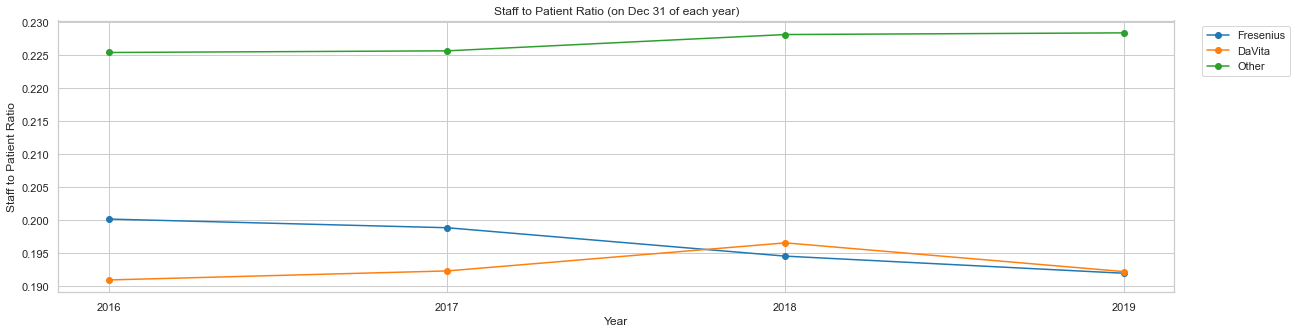

In [17]:
generate_chart(reporting_df, measure='spr', title='Staff to Patient Ratio (on Dec 31 of each year)', xlabel='Year', ylabel='Staff to Patient Ratio')

Clinics that are not part of the Fresenius or DaVita chains have the highest staff-to-patient ratio, on average.  Conversely, Fresenius and DaVita have comparable staff-to-patient ratios, with Fresenius being slightly lower in 2018 and 2019.  While low staff-to-patient ratios do not necessarily mean care will suffer, it could be an area to investigate if we find lower quality outcomes from the big chains.  On the other hand, if quality is even, or even better, from Fresenius and DaVita, then this lower staff ratios may just be an indication of improved efficiencies that can be achieved by these larger organizations.

***
Standardized Mortality Ratio
***

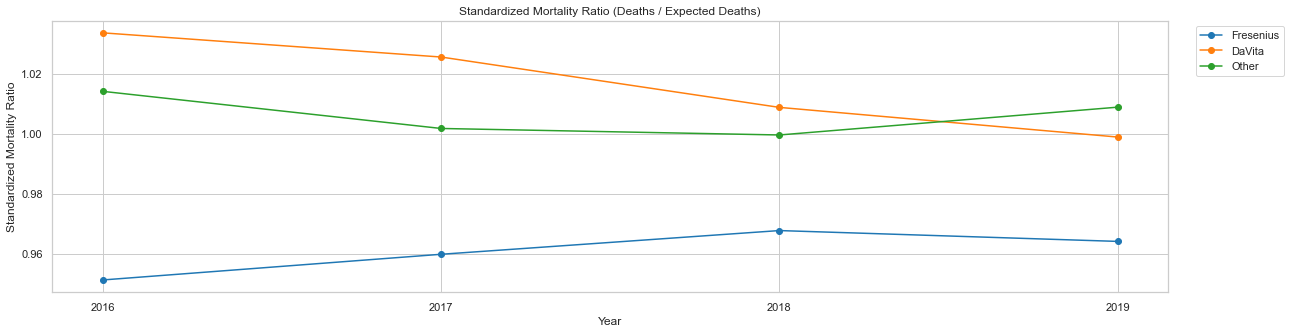

In [18]:
generate_chart(reporting_df, measure='smr', title='Standardized Mortality Ratio (Deaths / Expected Deaths)', xlabel='Year', ylabel='Standardized Mortality Ratio')

Fresenius has been able to achieve an SMR of < 1 for each year 2016-1018.  This means that the number of actual patient deaths each year was less than the number of patient deaths that would be statistically expected for the patient population.  In other words, Fresenius is consistently able to extend patient lives.  
  
DaVita and Other providers, however, achieve an SMR at, or slighter higher than, 1.0 for each year.  So patient lives were not extended beyond normal expectations.

***
Average UFR
***

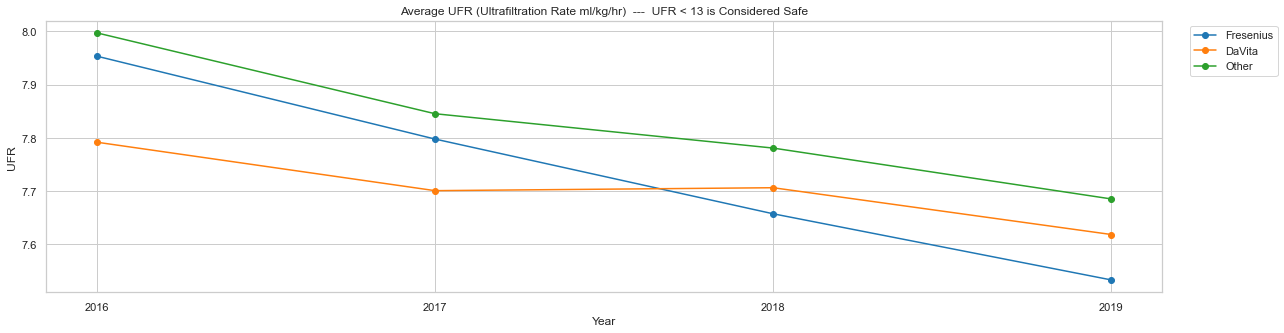

In [19]:
generate_chart(reporting_df, measure='ufr', title='Average UFR (Ultrafiltration Rate ml/kg/hr)  ---  UFR < 13 is Considered Safe', xlabel='Year', ylabel='UFR')

The ultrafiltration rate (UFR) indicates the speed of fluid removal during dialysis.  Fast UFRs can lead to patient complications, so this measurement is tracked to ensure the UFR is not too high.  All clinics have an average UFR that is significantly less than the safety threshold of 13 mg/kg/hr, and all declined over 2016-1018.  However, this doesn't show the full picture since it's an average over a large patient population.  Instead, it would be more instructive to see which clinics have the most patients that exceed the safety threshold, and we will look at that measurement next.

***
% Poor UFR
***

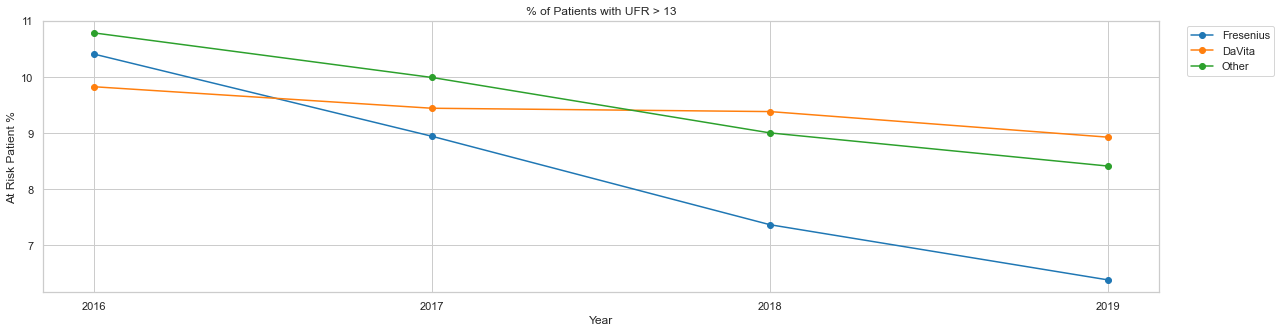

In [20]:
generate_chart(reporting_df, measure='badufrper', title='% of Patients with UFR > 13', xlabel='Year', ylabel='At Risk Patient %')

CMS defines poor UFR rates as those that exceed 13 ml/kg/hr.  To better see the quality outcomes for patients, we looked at the % of patients that exceeded this threshold for each provider type (Fresenius, DaVita, and Other).  As shown by the graph, Fresenius achieved the lowest percentage of Poor UFR measures of 2017-2019 and consistently improved in this outcome year over year.  
  
DaVita, however, has shown little improvement over this 4 year period and ended 2019 with the highest percentage of Poor UFR measurements.

***
Average Kt/V
***

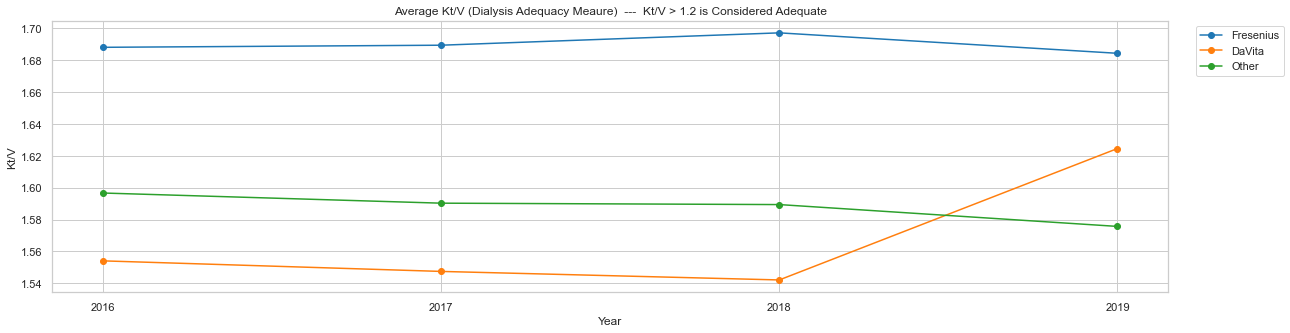

In [21]:
generate_chart(reporting_df, measure='ktv', title='Average Kt/V (Dialysis Adequacy Meaure)  ---  Kt/V > 1.2 is Considered Adequate', xlabel='Year', ylabel='Kt/V')

Kt/V is a common measurement that identifies the efficacy of a hemodialysis session.  Low Kt/V measurements are an indication the blood is not being adequately cleaned, so this measurement is tracked to ensure Kt/V is not too low.  All clinics have an average Kt/V that is significantly higher than the safety threshold of 1.2, with Fresenius achieving the highest average in each of the four years.  However, this doesn't show the full picture since it's an average over a large patient population.  Instead, it would be more instructive to see which clinics have the most patients that fall below the safety threshold, and we will look at that measurement next.

***
% Poor Kt/V
***

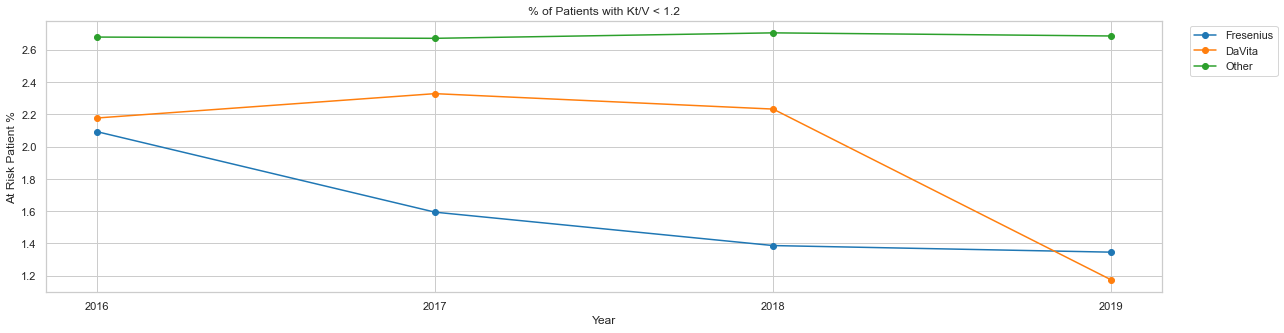

In [22]:
generate_chart(reporting_df, measure='badktvper', title='% of Patients with Kt/V < 1.2', xlabel='Year', ylabel='At Risk Patient %')

CMS defines poor Kt/V rates as those that are below 1.2.  To better see the quality outcomes for patients, we looked at the % of patients that were lower than this threshold for each provider type (Fresenius, DaVita, and Other).  As shown by the graph, Fresenius achieved the lowest percentage of Poor Kt/V measures from 2016-2018 and nearly matched DaVita's low benchmark in 2019.  Both Fresenius and DaVita improved significantly over the 4 year period - from approximately 2.1% of poor Kt/V measurements in 2016 to approximately 1.3% of poor Kt/V measurements in 2019.
  
Other clinic providers (not Fresenius nor DaVita), however, have shown little improvement over this 4 year period.  Each year, they had the highest percentage of patients (~2.7%) with poor Kt/V measurements, and this remained consistent over the four years.

***
### Conclusion

While we only analyzed a small subset of the available data, the analysis shows a preliminary indication that Fresenius leads both DaVita and Other providers on key quality measures.    
* Lowest Standardized Mortality Ratio
* Lowest Average UFR and Lowest % of Poor UFR measurements
* Highest Kt/V rating and Lowest %`*` of Poor Kt/V measurements (`*` Lowest in 2016-2018 and near match for lowest in 2019)   

Interestingly, the staff to patient ratio for Fresenius is the smallest across the evaluated groups.  A possible explanation for this is a high level of efficiency among that staff, while still maintaining high quality.

***
### Afterthoughts

We have only scratched the surface on the data analysis that can be done with the recorded data.  Future paths for analysis include...
* State level variances
* Clinic level variances
* Additional key measures with a GMO focus
* Quality review with specific providers other than DaVita.  Do any match or exceed Fresenius quality levels?
